# 0.0 Imports 

In [1]:
import random
import pickle
import requests


import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb


from IPython.display      import Image
from pandas_profiling     import ProfileReport
from IPython.core.display import HTML

from boruta                        import BorutaPy
from sklearn                       import tree
from sklearn                       import svm
from catboost                      import CatBoostClassifier
from lightgbm                      import LGBMClassifier
from sklearn.dummy                 import DummyClassifier
from sklearn.metrics               import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics               import precision_score, accuracy_score, f1_score, recall_score, brier_score_loss, roc_curve
from imblearn.combine              import SMOTETomek
from sklearn.ensemble              import RandomForestClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.linear_model          import LogisticRegression,SGDClassifier
from sklearn.model_selection       import StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing         import MinMaxScaler, RobustScaler








## 0.1 Helper functions

In [2]:
def calculate_model_metrics( y_test, y_pred ):
    
    #calculate precision
    precision = precision_score( y_test, y_pred)

    #calculate accuracy
    accuracy = accuracy_score( y_test, y_pred)

    #calculate f1_score
    f1 = f1_score( y_test, y_pred)

    #calculate recall
    recall = recall_score( y_test, y_pred)
    
    return precision, accuracy, f1, recall
    
def get_classifiers_performance(X_train, X_test, y_train, y_test, classifiers):

        # creates empty data frame
        df_performance = pd.DataFrame()

        for clf in classifiers:
            print("Training " + type(clf).__name__ + "...")
            # fits the classifier to training data
            clf.fit(X_train, y_train)

            # predict the probabilities
            y_pred = clf.predict(X_test)

            # calculates model metrics
            clf_precision, clf_accuracy, clf_f1, clf_recall = calculate_model_metrics( y_test, y_pred)

            # creates a dict
            clf_dict = {
                'model': [type(clf).__name__, '---'],
                'precision': [clf_precision, np.nan],
                'recall': [clf_recall, np.nan],
                'f1-Score': [clf_f1, np.nan],
                'accuracy': [clf_accuracy, np.nan]}

            # concatenate Data Frames
            df_performance = pd.concat([df_performance, pd.DataFrame(clf_dict)])

        # resets Data Frame index
        df_performance = df_performance.reset_index()

        # drops index
        df_performance.drop('index', axis=1, inplace=True)

        # gets only the odd numbered rows
        rows_to_drop = np.arange(1, len(classifiers)*2, 2)

        # drops unwanted rows that have no data
        df_performance.drop(rows_to_drop, inplace=True)

        # returns performance summary
        return df_performance

def plot_single_confusion_matrix(y_test, y_pred, model, qualifier=""):
    # calculates confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # plots confusion matrix as heatmap
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap='viridis',
                             square=True, annot_kws={"size": 15})

    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    ax.title.set_text(type(model).__name__ + ' ' + str(qualifier))

def plot_multiple_confusion_matrices(n_rows, n_cols, X_test, y_test, classifiers, threshold):
        # define subplots
        fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

        for clf, ax, n in zip(classifiers, ax.flatten(), list(range(n_rows*n_cols))):

            # predict the probabilities
            clf_probs = clf.predict_proba(X_test)

            # keeps probabilities for the positive outcome only
            probs = pd.DataFrame(clf_probs[:, 1], columns=['prob_default'])

            # applied the threshold
            y_pred = probs['prob_default'].apply(
                lambda x: 1 if x > threshold else 0)

            # plots confusion matrix as heatmap
            plt.subplot(n_rows, n_cols, n+1)
            plot_single_confusion_matrix(y_test, y_pred, clf)

        # adjusts subplot
        plt.tight_layout()

        # displays the plot
        plt.show()



In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Populating the interactive namespace from numpy and matplotlib


/home/pc/anaconda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2 Data Loading

In [5]:
#open csv file

df_raw = pd.read_csv('../data/cardio_train.csv')


# 1.0 Data Description

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns 

In [7]:
df1.columns


Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')


Don't need to rename any columns

## 1.2 Data Dimensions

In [8]:
print("Number of rows {}".format(df1.shape[0]))
print("Number of cols {}".format(df1.shape[1]))

Number of rows 70000
Number of cols 13


## 1.3 Data Types 

In [9]:
df1.dtypes


id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object


All types seems correct

## 1.4 Check NA 


In [10]:
df1.isna().sum()


id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


As observed, don't has NA in the dataset
    

## 1.5 Descriptive Statistical

In [11]:
#Central tendency - mean, median
ct1 = pd.DataFrame(df1.apply(np.mean)).T
ct2 = pd.DataFrame(df1.apply(np.median)).T

#dispersion - std, min, max,  range, skew, kurtosis
d1 = pd.DataFrame(df1.apply(np.std)).T
d2 = pd.DataFrame(df1.apply(min)).T
d3 = pd.DataFrame(df1.apply(max)).T
d4 = pd.DataFrame(df1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

m.columns = ['Atrib.','min','max','range','mean','median','std','skew','kurtosis']

In [12]:
m

Atrib.         min         max       range        mean      median         std     skew   kurtosis
0            id     0.00000 99999.00000 99999.00000 49972.41990 50001.50000 28851.09624 -0.00128   -1.19837
1           age 10798.00000 23713.00000 12915.00000 19468.86581 19703.00000  2467.23404 -0.30706   -0.82345
2        gender     1.00000     2.00000     1.00000     1.34957     1.00000     0.47683  0.63096   -1.60194
3        height    55.00000   250.00000   195.00000   164.35923   165.00000     8.21007 -0.64219    7.94365
4        weight    10.00000   200.00000   190.00000    74.20569    72.00000    14.39565  1.01207    2.58683
5         ap_hi  -150.00000 16020.00000 16170.00000   128.81729   120.00000   154.01032 85.29621 7580.07474
6         ap_lo   -70.00000 11000.00000 11070.00000    96.63041    80.00000   188.47118 32.11408 1425.91458
7   cholesterol     1.00000     3.00000     2.00000     1.36687     1.00000     0.68025  1.58712    0.99390
8          gluc     1.00000     3.00000     2.00000     1.22646     1.00000     0.57227  2.39746    4.29438
9         smoke     0.00000     1.00000     1.00000     0.08813     0.00000     0.28348  2.90587    6.44425
10         alco     0.00000     1.00000     1.00000     0.05377     0.00000     0.22557  3.95661   13.65513
11       active     0.00000     1.00000     1.00000     0.80373     1.00000     0.39718 -1.52947    0.33930
12       cardio     0.00000     1.00000     1.00000     0.49970     0.00000     0.50000  0.00120   -2.00006

We have some **key points**:
    
  - Systolic blood pressure min (ap_hi) is -150
  - Systolic blood pressure (ap_hi) max is 16020
  - Diastolic blood pressure (ap_lo) min is -70
  - Diastolic blood pressure (ap_lo) max is 11000
  - Min height is 55 cm and max is 250 cm
  - min weight is 10 kg and max is 200 kg
  
 
    

# 2.0 Feature Engineering

In [13]:
df2 =df1.copy()

## 2.1 Mind Map

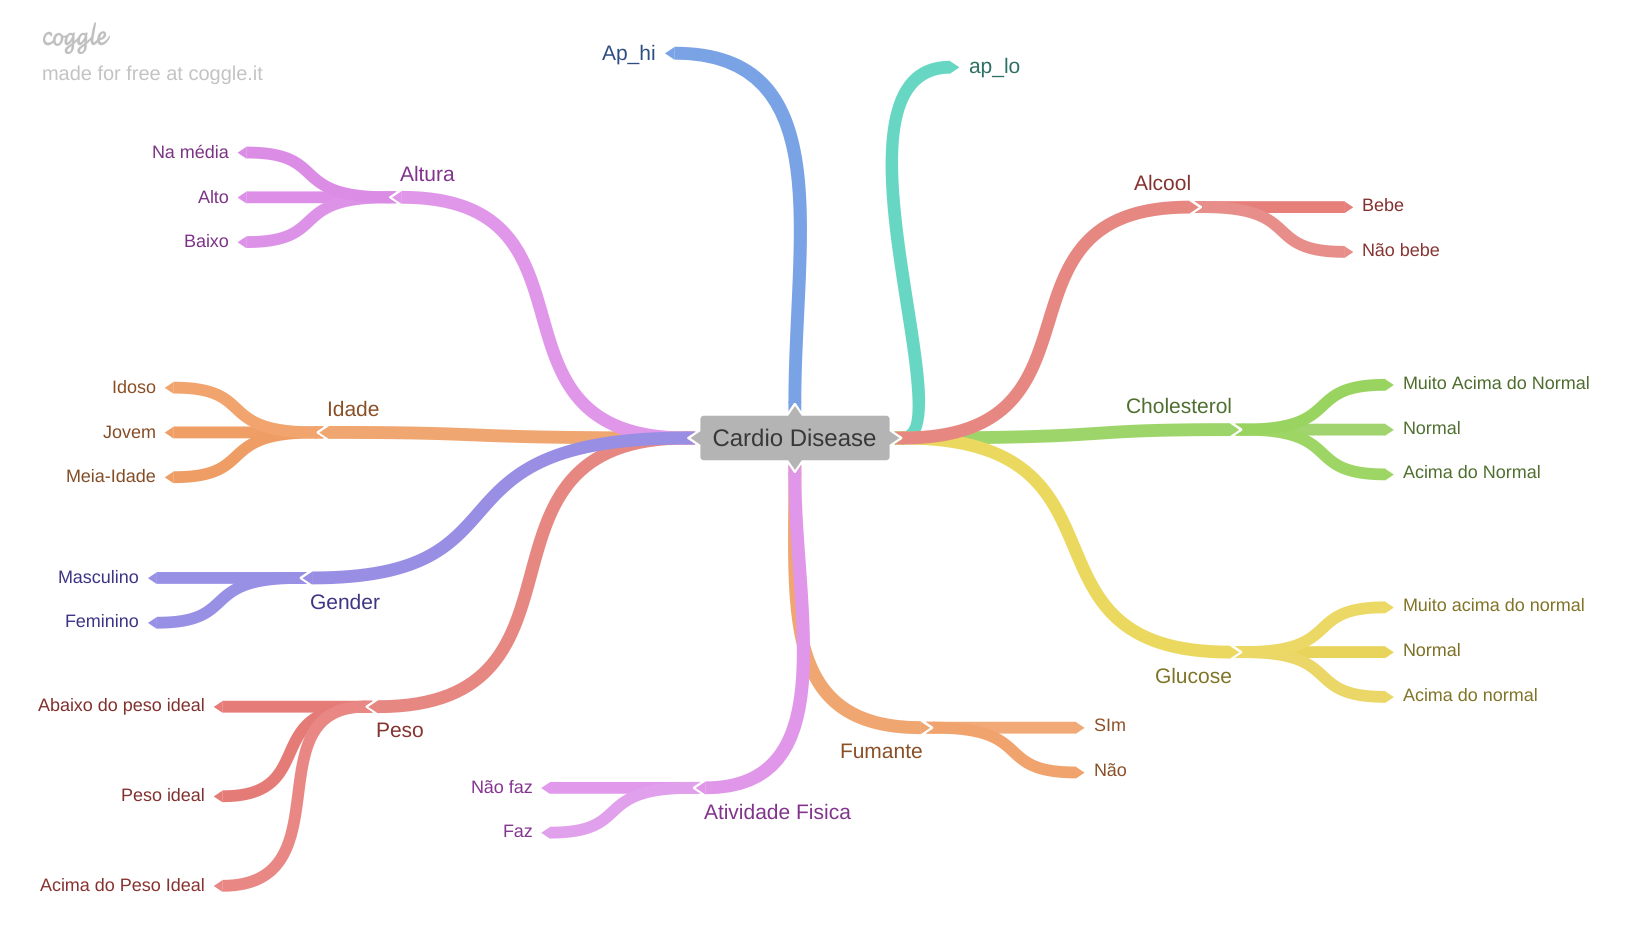

In [14]:
Image('img/mind_map_cardio.png')

## 2.1 Creating Hypotheses

 - H1- Heart disease cases depend significantly on the ideal weight (BMI)
 
 - H2- Older people should be more likely to have heart disease
 
 - H3- people who smoke should be more likely to be heart disease
 
 - H4- People who intake alcohol should be more likely to have heart diseases
 
 - H5- People who do not practice physical activity should be more likely to have heart disease
 
 - H6- There are more cases of heart diseases for people presenting well above normal levels of cholesterol
 
 - H7- There are more cases of heart diseases for people presenting High Stage 2 level of blood pressure
 
 - H8- There are more cases of heart diseases for people presenting well above normal levels of glucose
 
 - H9 Men should be more likely to get cardio disease than women.

## 2.2 Feature Engineering

In [15]:
#blood_pressure
# 1 - ap_hi < 120 e ap_lo < 80 
# 2 -  120<= ap_hi <= 129 e ap_lo < 80
# 3 -  130<= ap_hi <= 139 e 80 <= ap_lo <= 89
# 4 -  139 < ap_hi  e 89 < ap_lo 

df2['blood_pressure'] = df2.apply( (lambda x: 1 if (x['ap_hi'] < 120) & (x['ap_lo'] <= 80) else 2 if (120 <= x['ap_hi'] <= 129) & (x['ap_lo'] < 80) else 3 if (130 <= x['ap_hi'] < 139) or ( 80 <= x['ap_lo'] <= 89) else 4 ),axis =1 ) 


#IMC = WEIGHT/HEIGHT^2
df2['height2'] = df2['height']/100

df2['bmi'] = (df2['weight']/(df2['height2']**2))

#imc_type
df2['bmi_type'] = df2.apply( (lambda x : 1 if x['bmi'] < 18.5 else 2 if  18.5 <= x['bmi'] < 25.0 else 3 if 25 <= x['bmi'] < 30.0 else 4 if  30.0 <= x['bmi'] < 35.0 else 5 if 35 <= x['bmi'] < 40.0 else 6) ,axis=1)

#create columns age by year
df2['age_years'] = df2['age'].apply(lambda x: x/365)

#round
df2['age_years'] = round(df2['age_years'], ndigits=0).astype(int)



## 2.3 Delete auxiliary columns

In [16]:
cols_drop = ['height2']
df2 = df2.drop(cols_drop,axis=1)

## 2.4 Removing Outliers 

As observed in 1.5 section, we find outliers on two columns:

 - ap_hi
 - ap_lo
 - height
 - weight
 
let's remove the outliers

### 2.4.1 Diastolic and Systolic 

we will consider the medical diagnosis and the boundaries that it defines for Systolic and Diastolic:

For **Systolic (ap_hi)**:

   - Low outliers are values lower or equal to 50
   - High outliers are values higher or equal to 210
   
For **Diastolic (ap_lo)**:
    
   - Low outliers are values lower or equal to 35
   - High outliers are values higher or equal to 120 
   
Source : https://www.etoolsage.com/Chart/Blood_Pressure_Chart.asp


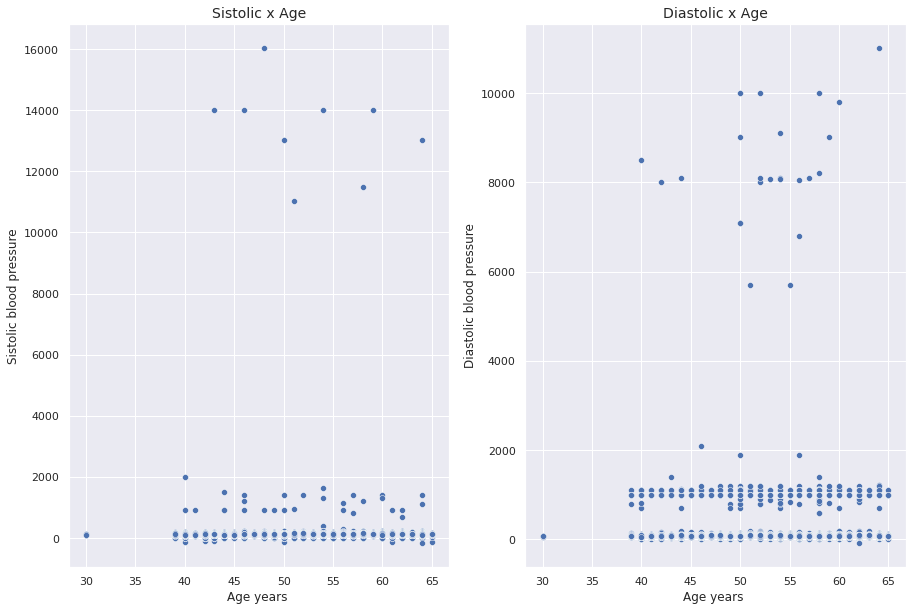

In [17]:
#by scatter plot
plt.subplot(1 ,2 ,1)
sns.scatterplot(data =df2, y='ap_hi', x = 'age_years')
plt.xlabel("Age years ")
plt.ylabel("Sistolic blood pressure")
plt.title("Sistolic x Age" , fontsize = 14);


plt.subplot(1 ,2 ,2)
sns.scatterplot(data =df2, y='ap_lo', x = 'age_years')
plt.xlabel("Age years ")
plt.ylabel("Diastolic blood pressure")
plt.title("Diastolic x Age", fontsize = 14);

plt.show();


In [18]:
#removing outliers
df2 = df2[ ~ ((df2['ap_hi'] <= 50 ) | (df2['ap_hi'] >= 210 )
              | (df2['ap_lo'] <= 35 ) | (df2['ap_lo'] >= 120 ) )]



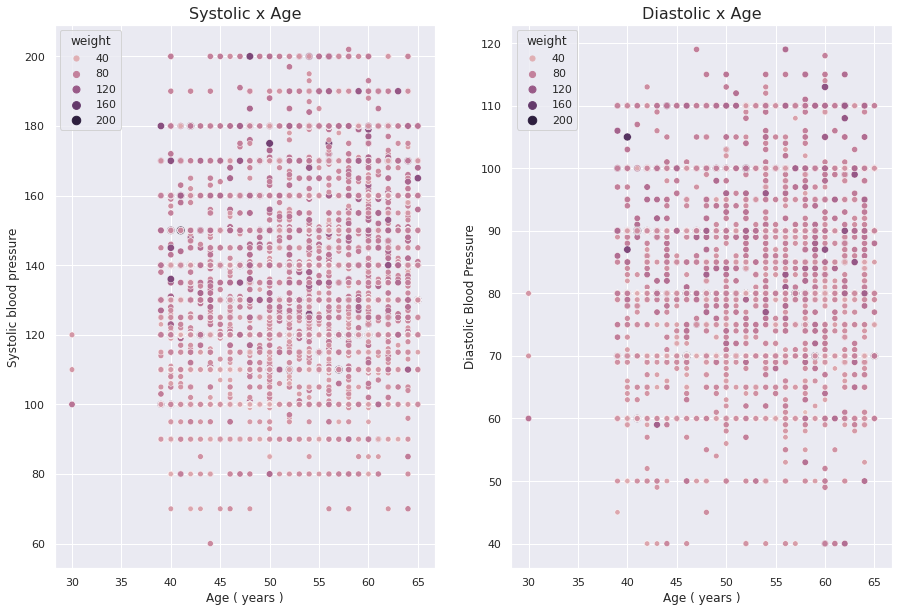

In [19]:
#scatter plot

plt.subplot(1,2,1)
sns.scatterplot(data =df2, y='ap_hi', x = 'age_years', hue='weight',size='weight');
plt.ylabel("Systolic blood pressure");
plt.xlabel("Age ( years )");
plt.title("Systolic x Age" , fontsize=16);

plt.subplot(1 ,2 ,2 )

#check scatter plot
sns.scatterplot( data =df2 , x = 'age_years' , y='ap_lo', hue = 'weight', size= 'weight' );
plt.xlabel("Age ( years )")
plt.ylabel("Diastolic Blood Pressure");
plt.title("Diastolic x Age" , fontsize=16);

Now the distribution are more clear, we can check the values in deeper details

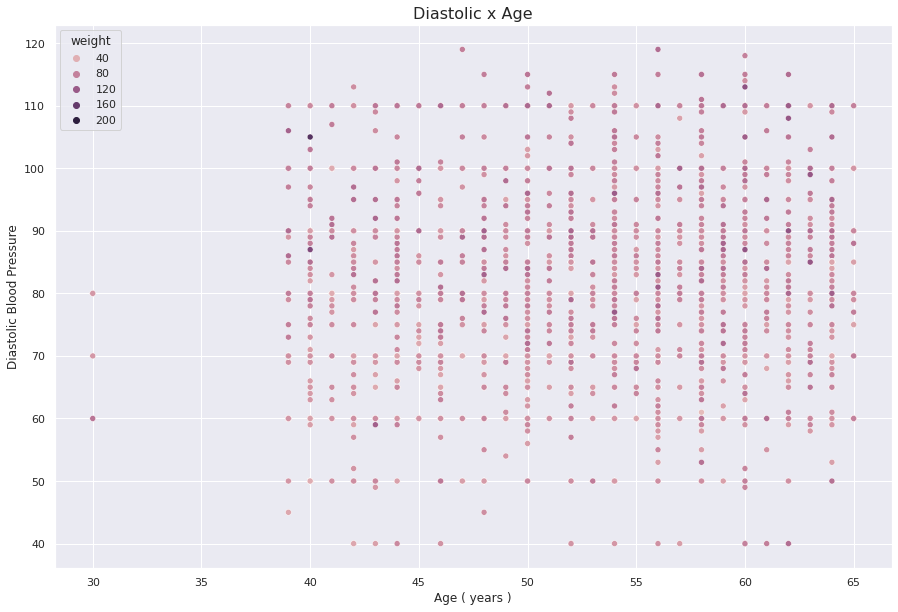

In [20]:
#check scatter plot
sns.scatterplot( data =df2 , x = 'age_years' , y='ap_lo', hue = 'weight' );
plt.xlabel("Age ( years )")
plt.ylabel("Diastolic Blood Pressure");
plt.title("Diastolic x Age" , fontsize=16);

### 2.4.2 Height and Weight

For Height and Weight we will consider outliers by looking at the boxplot 

/home/pc/anaconda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


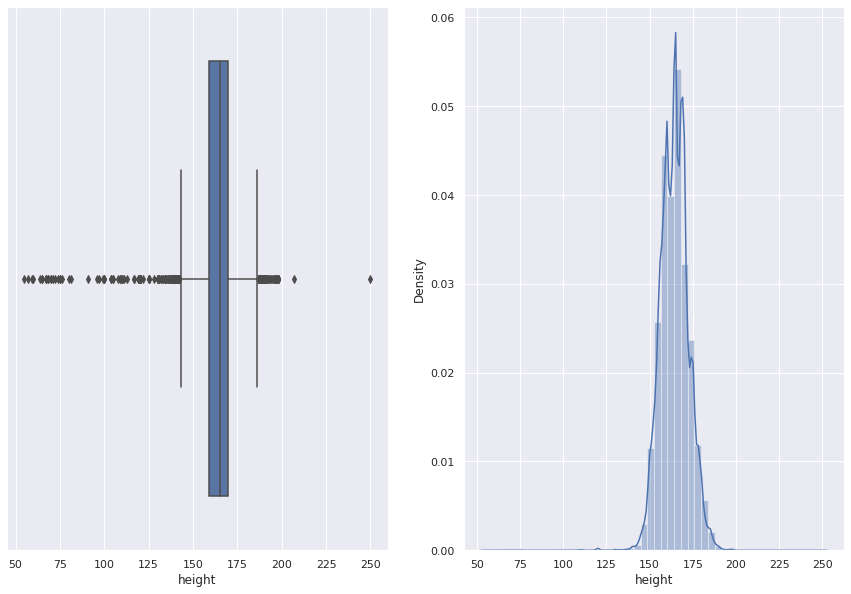

In [21]:
#height
plt.subplot(1 ,2 ,1 )
sns.boxplot(x=df2['height'] )

plt.subplot(1 ,2 ,2 )
sns.distplot( df2['height']);


For Height:
- Low outliers are values lower or equal to 120 cm
- High outliers are values higher or equal to 200 cm

In [22]:
#removing outliers
df2 = df2[~ ( (df2['height'] <= 120) | (df2['height'] > 200 ) ) ]

/home/pc/anaconda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


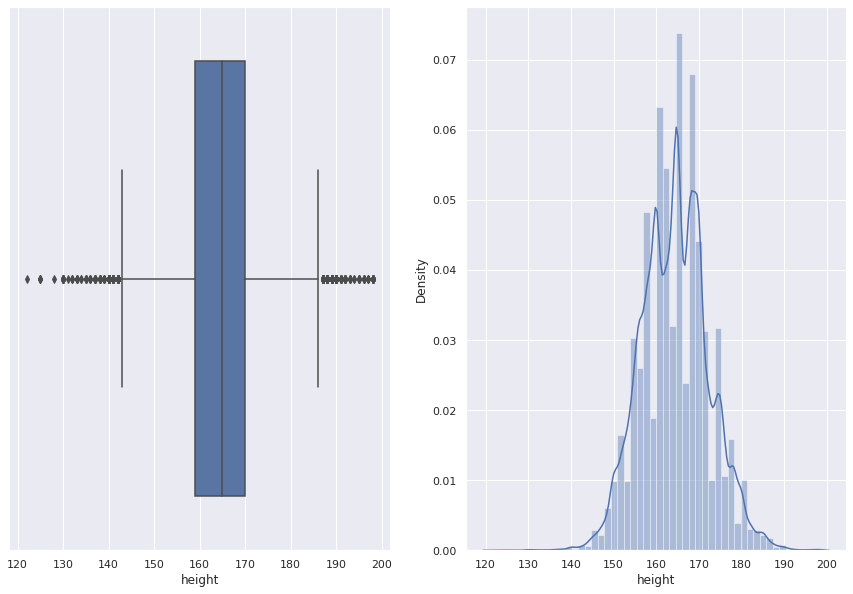

In [23]:
#height
plt.subplot(1 ,2 ,1 )
sns.boxplot(x=df2['height'] )

plt.subplot(1 ,2 ,2 )
sns.distplot( df2['height']);

/home/pc/anaconda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


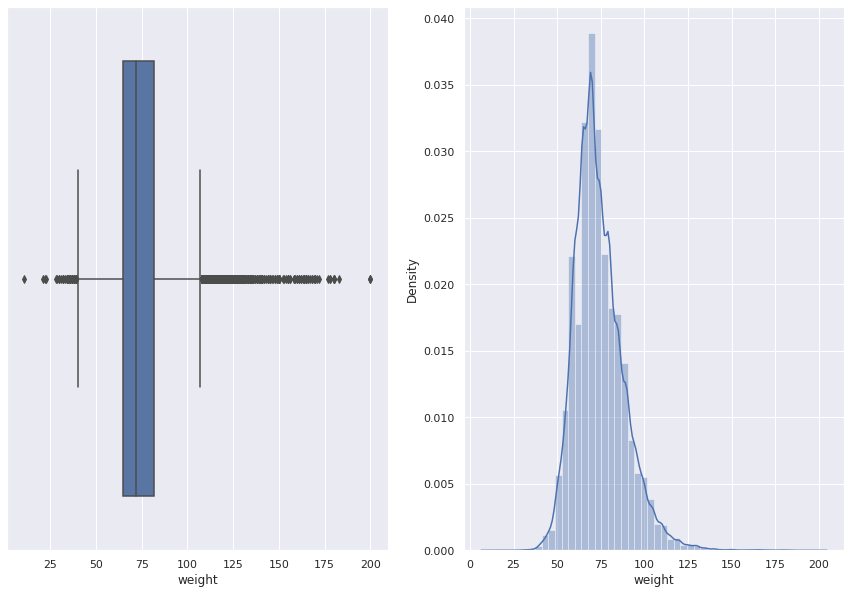

In [24]:
#height
plt.subplot(1 ,2 ,1 )
sns.boxplot(x=df2['weight'] )

plt.subplot(1 ,2 ,2 )
sns.distplot( df2['weight']);

For Weight:
- Low outliers are values lower or equal 30kg
- High outliers are values higher or equal to 175 kg

In [25]:
#removing outliers
df2 = df2[~ ( (df2['weight'] <= 30) | (df2['weight'] >= 175 ) ) ]

/home/pc/anaconda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


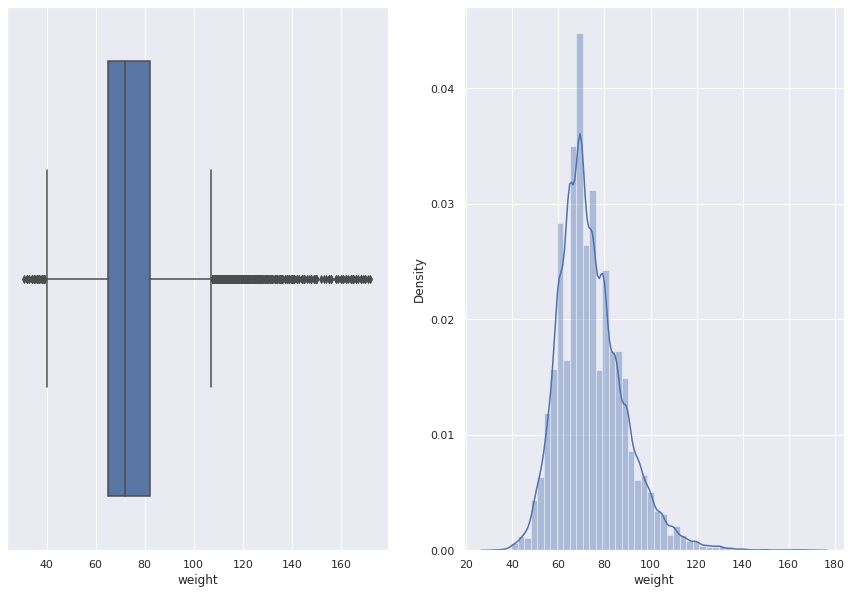

In [26]:
#height
plt.subplot(1 ,2 ,1 )
sns.boxplot(x=df2['weight'] )

plt.subplot(1 ,2 ,2 )
sns.distplot( df2['weight']);

# 3.0 EDA

In [27]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.2 Numerical Variables

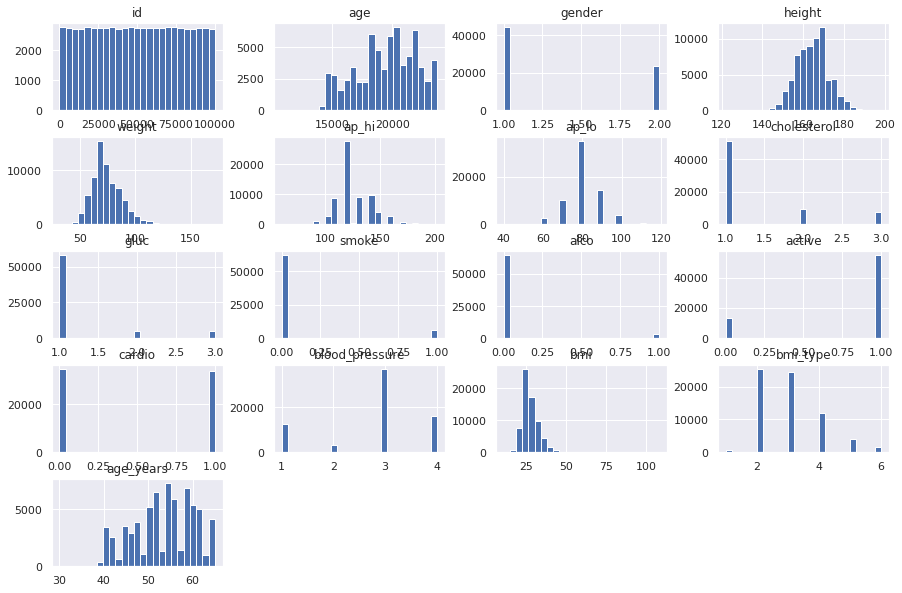

In [28]:
df3.hist(bins=25);

In [29]:
#more detailed plot of variables

#ProfileReport(df3, title="Pandas Profiling Report")


## 3.2 Bivariate Analysis

### H1- Heart disease cases depend significantly on the ideal weight (BMI)
**TRUE**

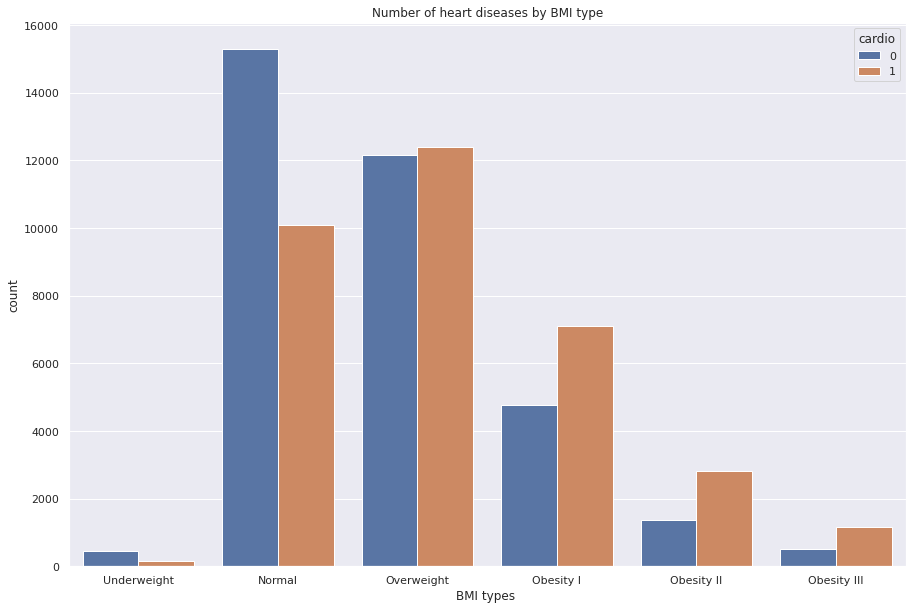

In [30]:
#plots graph
sns.countplot(x='bmi_type', hue='cardio', data=df3);

#label
plt.title("Number of heart diseases by BMI type");
plt.xlabel("BMI types ");
plt.xticks(ticks=[0,1,2,3,4,5], labels = ['Underweight', 'Normal', 'Overweight' , 'Obesity I' ,'Obesity II' , 'Obesity III'] );
#plt.show()


- As observed , **above ideal weight** is **more likely** to have heart diseases 

### H2- Older people should be more likely to have heart disease


**TRUE** 


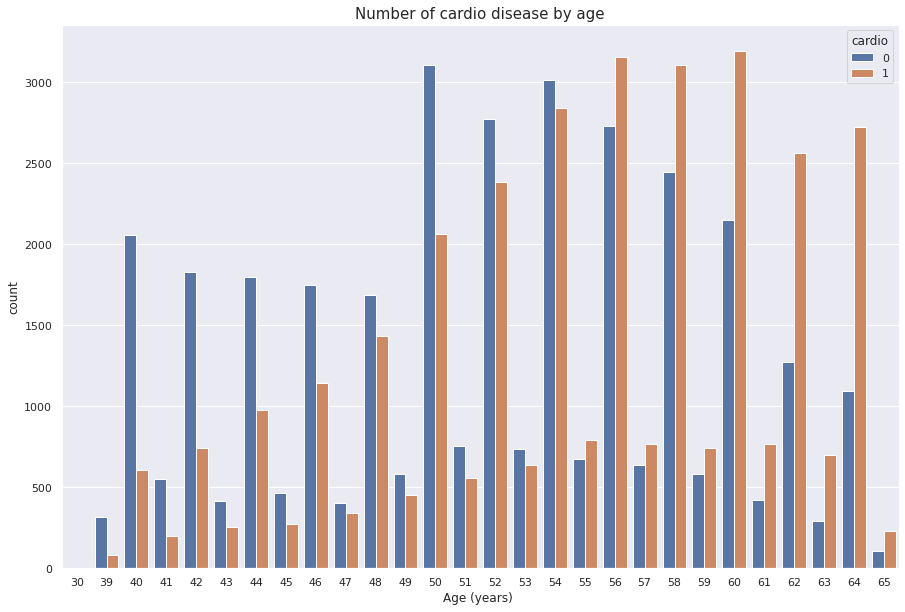

In [31]:

#plot graph
sns.countplot(x='age_years',hue='cardio',data=df3);
plt.xlabel("Age (years) ");
plt.title("Number of cardio disease by age", fontsize = 15);



- As observed, from **55 years** of age is **more likely** to have heart disease

### H3- people who smoke should be more likely to be heart disease
**FALSE** 

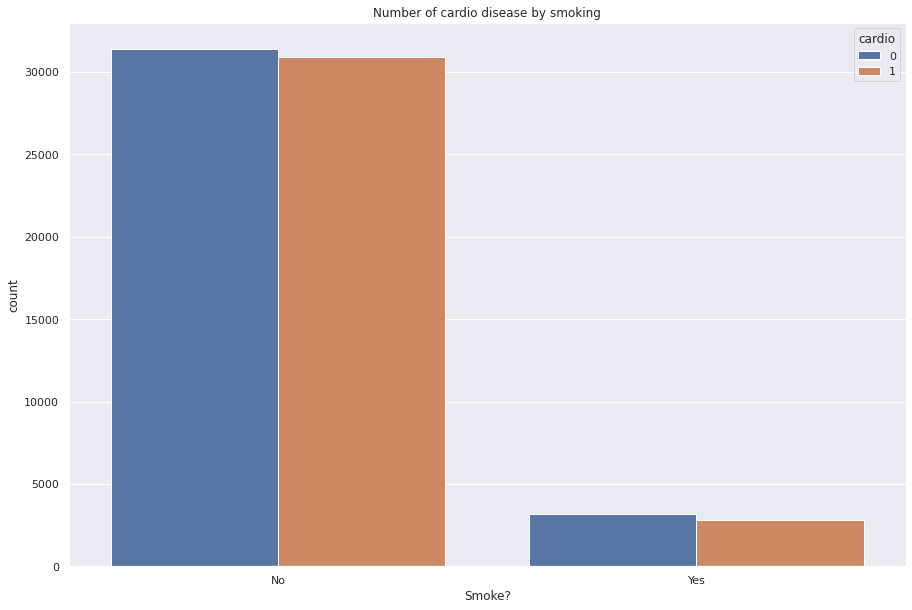

In [32]:
#plots graph
sns.countplot(x='smoke',hue='cardio', data=df3);

plt.xticks(ticks=[0,1] , labels=['No', 'Yes'])

plt.xlabel("Smoke?")
plt.title("Number of cardio disease by smoking");


- As observed, It is **not more likely** among those who smoke

### H4- People who intake alcohol should be more likely to have heart diseases

**False** 

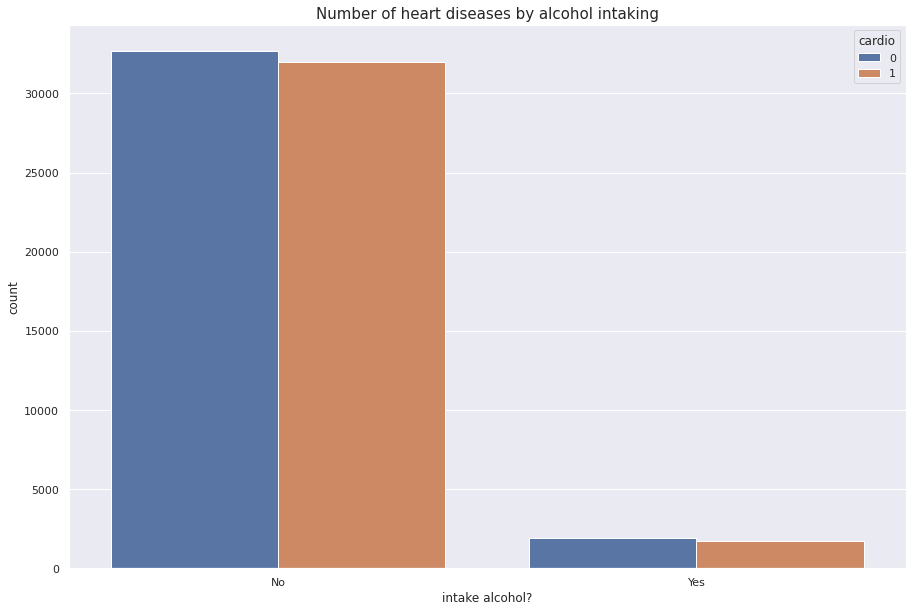

In [33]:
#plot graph
sns.countplot(x='alco',hue='cardio',data =df3);

plt.title("Number of heart diseases by alcohol intaking" , fontsize=15)
plt.xlabel("intake alcohol?");
plt.xticks( ticks=[0,1], labels=['No', 'Yes']);

As observed,it is **not more** likely among those who intake alcohol

### H5- People who do not practice physical activity should be more likely to have heart disease
**True** 

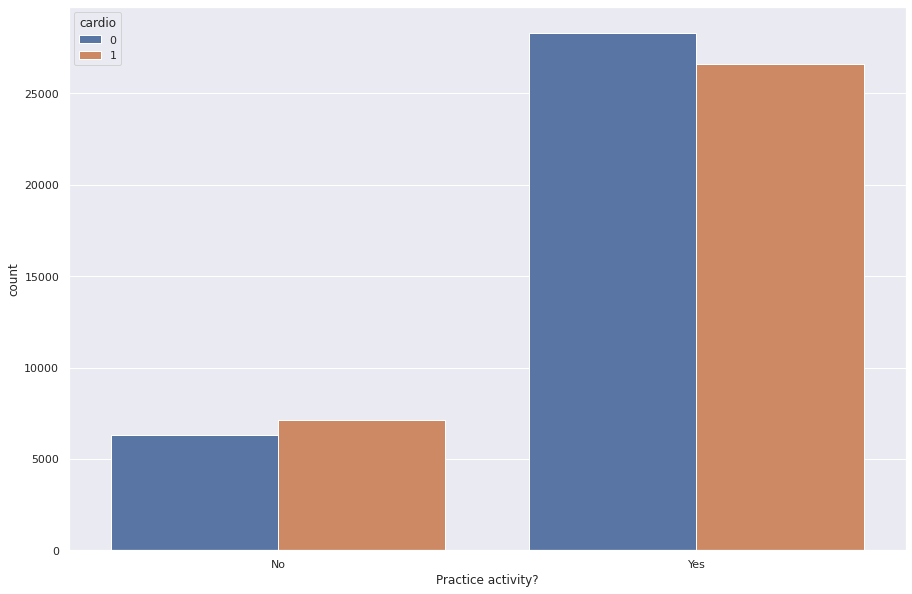

In [34]:
#plot graph
sns.countplot(x='active', hue= 'cardio',data = df3);

plt.xlabel("Practice activity?");
plt.xticks( ticks=[0,1] , labels=['No', 'Yes']);


As observed,People who **do not practice physical activity** are more likely

### H6- There are more cases of heart diseases for people presenting well above normal levels of cholesterol
**True**

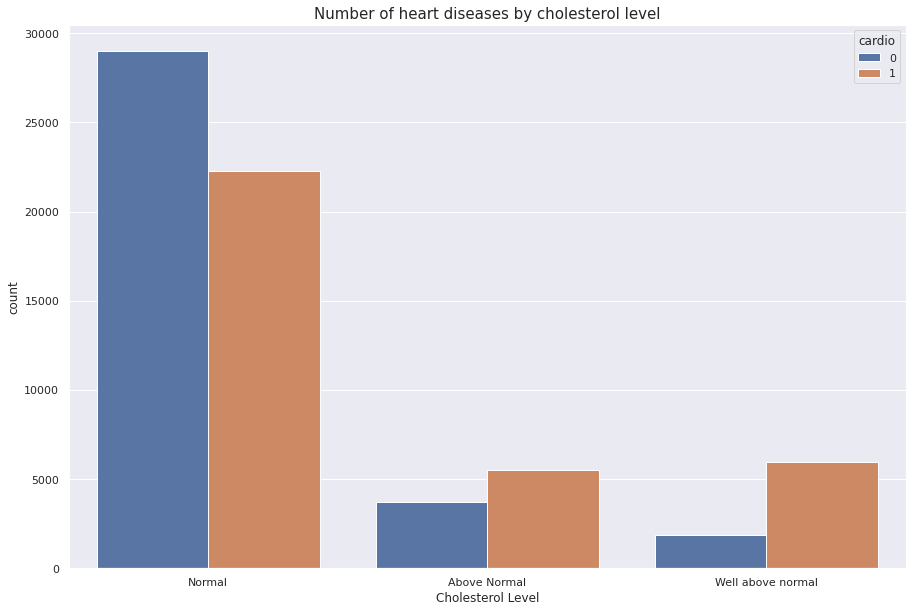

In [35]:
#plot graph
sns.countplot(x = 'cholesterol', hue= 'cardio', data = df3);

plt.xticks(ticks=[0,1,2],labels=['Normal','Above Normal','Well above normal']);
plt.title("Number of heart diseases by cholesterol level" ,  fontsize=15);
plt.xlabel("Cholesterol Level");


### H7- There are more cases of heart diseases for people presenting High Stage 2 level of blood pressure
**TRUE**

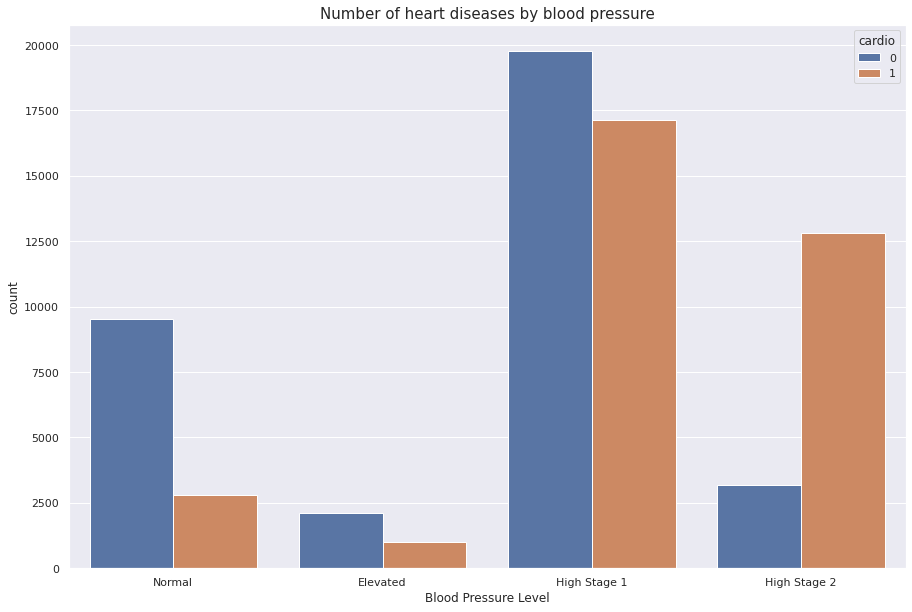

In [36]:
#plot graph
sns.countplot(x='blood_pressure', hue = 'cardio' ,data = df3);

plt.xticks(ticks=[0,1,2,3] , labels=['Normal', 'Elevated', 'High Stage 1' , 'High Stage 2']);
plt.xlabel("Blood Pressure Level")
plt.title("Number of heart diseases by blood pressure", fontsize =15);



### H8- There are more cases of heart diseases for people presenting well above normal levels of glucose
**TRUE**

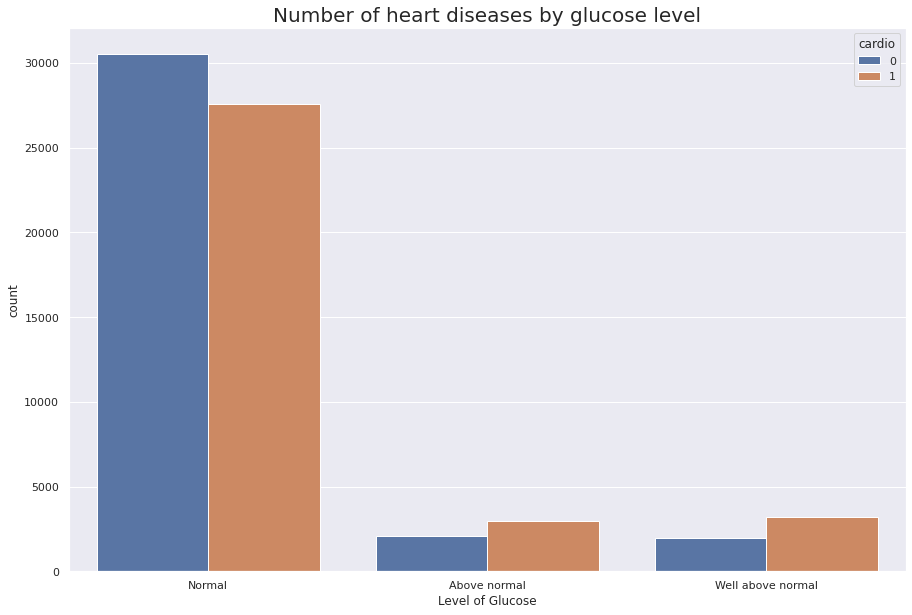

In [37]:

#plot graph
sns.countplot(x = 'gluc' , hue = 'cardio',data = df3);

plt.title("Number of heart diseases by glucose level",fontsize=20);
plt.xlabel("Level of Glucose");
plt.xticks(ticks=[0,1,2],labels=['Normal','Above normal','Well above normal']);


### H9 Men should be more likely to get cardio disease than women.
**FALSE**



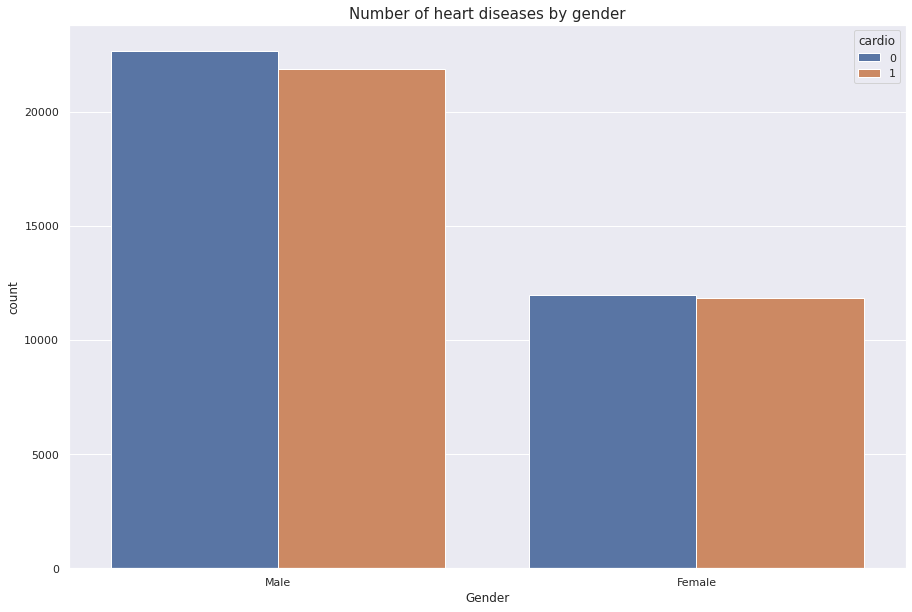

In [38]:

sns.countplot(x = 'gender', hue = 'cardio', data = df3);
plt.title("Number of heart diseases by gender" , fontsize=15);
plt.xticks(ticks=[0,1],labels=['Male','Female']);
plt.xlabel("Gender");


## 3.3 Multivariate analysis

### 3.3.1 Numerical variables

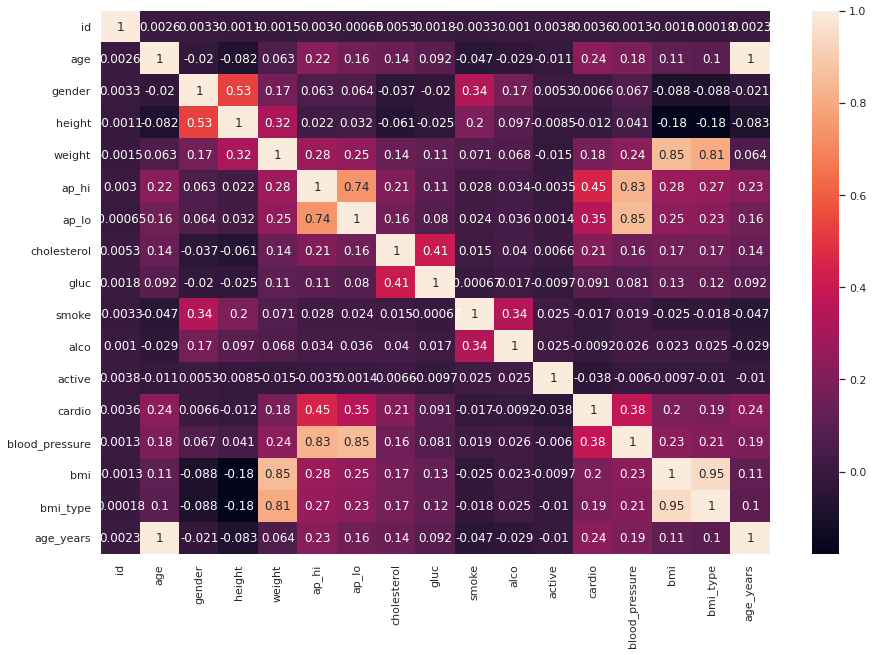

In [39]:
num = df3.select_dtypes(include = ['float64', 'int64'])
corre = num.corr(method = 'spearman')
sns.heatmap(corre,annot=True);

As observed, **age, weight ,ap_hi, ap_lo, cholesterol, blood_pressure, bmi has considerable relevance**

### 3.3.2 Categorical Variables


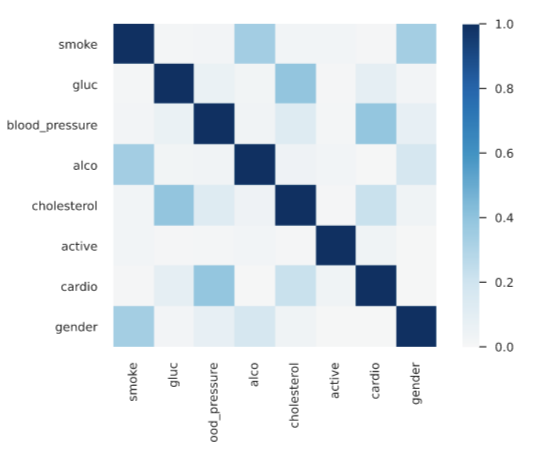

In [40]:
Image('img/Cramer.png')

# 4.0  Split train and Test dataset 

In [41]:
df4 = df3.copy()

In [42]:
#training data set
x_train, x_test, y_train, y_test = train_test_split(df4,df4['cardio'], random_state = 42, test_size= 0.25)

In [43]:
#delete columns
x_train = x_train.drop( [ 'id','cardio','age_years'], axis=1 )
x_test = x_test.drop( ['id','cardio','age_years'], axis=1  )



# 5.0 Feature Selection

In [44]:
df5 = df4.copy()

## 5.1 Boruta as Feature selector 

In [45]:
# #define model
# rf_model = RandomForestClassifier(n_jobs = -1)

# x_train_boruta = x_train.values
# y_train_boruta = y_train.values.ravel()


# #boruta
# boruta = BorutaPy( rf_model, n_estimators= 'auto', verbose =2, random_state=33  ).fit(x_train_boruta, y_train_boruta )

In [46]:
# #cols boruta
# cols = boruta.support_.tolist()
# cols_boruta = x_train.iloc[:, cols ].columns.to_list()
# cols_boruta


## 5.2 Manual Feature Selection


We will join the selected variables by boruta with the variables that we consider relevant in the exploratory data analysis

In [47]:
#features
cols_boruta_full = ['age','ap_hi','bmi','weight','cholesterol','blood_pressure','ap_lo']

In [48]:
# #filter datasets
x_train_boruta = x_train[cols_boruta_full].copy()
x_test_boruta = x_test[cols_boruta_full].copy()



# 6.0 Machine Learning Models

In [49]:
#copy data for training
x_train = x_train_boruta.copy()
x_test = x_test_boruta.copy()

## 6.1 Balancing data for training

In [50]:
# count values before balancing
y_train.value_counts()

0    25891
1    25368
Name: cardio, dtype: int64

In [51]:
#resampler
resampler =  SMOTETomek( random_state =33, n_jobs=1 )

#balacing
x_balanced, y_balanced = resampler.fit_resample( x_train, y_train )

In [52]:
#count values after balancing
y_balanced.value_counts()

0    20904
1    20904
Name: cardio, dtype: int64

## 6.2 Models 

In [53]:
seed = 33
#MODEL Dummy
dum = DummyClassifier()

#model catboost
cat = CatBoostClassifier(random_state=seed, verbose=False)

#MODEL Gaussian
gnb = GaussianNB()

# 
rfc = RandomForestClassifier(random_state=seed)

#MODEL Logistic Regression
lr = LogisticRegression()

#MODEL LDA
lda = LinearDiscriminantAnalysis()

# Kneighbors
knc = KNeighborsClassifier(n_neighbors=5,  weights='distance',n_jobs=-1)


#MODEL XGBClassifier
xgb = xgb.XGBClassifier(objective='binary:logistic')


#MODEL SGDC
sgd = SGDClassifier(loss='log', random_state = seed, n_jobs=-1)


#MODEL LGBM
lgbm = LGBMClassifier(random_state = seed, n_jobs=-1)


## 6.3 Model's Performance 

In [54]:
#training models
clfs =[lgbm, sgd ,lda, xgb, lr, gnb, cat, knc]         
df_perf = get_classifiers_performance( x_balanced, x_test, y_balanced, y_test , clfs )       


Training LGBMClassifier...
Training SGDClassifier...
Training LinearDiscriminantAnalysis...
Training XGBClassifier...
[18:23:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/pc/anaconda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training LogisticRegression...
Training GaussianNB...
Training CatBoostClassifier...


/home/pc/anaconda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training KNeighborsClassifier...


In [55]:
#highlight max value 
df_perf.style.highlight_max(color='yellow')

- On the **business** side, aiming for precision
- On the **patient** side, aiming for recall, as we are trying to minimize the false negative rate

We need a balance between precision and recall, f1-score as a metric that can provide us this balance.
That's why, the algorithm that satisfies this need is LGMClassifier

## 6.4 Confusion Matrix

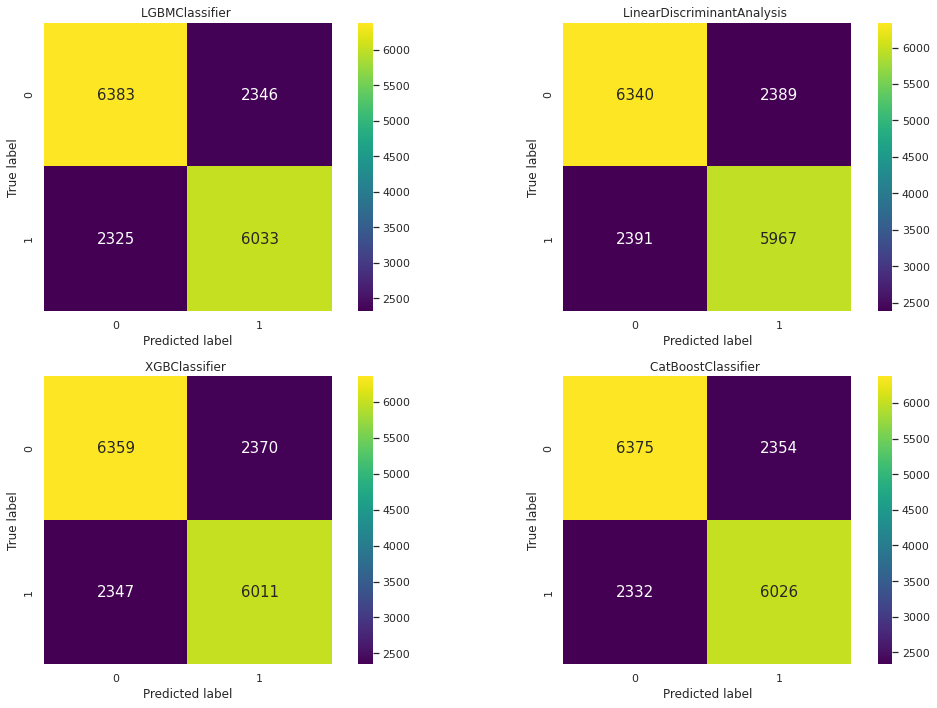

In [56]:
#lets take top 4 in f1-score
clfs_cm = [lgbm,lda,xgb, cat]

#set threshold
thresh = 0.45

#plot confusion matrix
plot_multiple_confusion_matrices(2, 2, x_test, y_test,clfs_cm , thresh )




- **LGBM** has the lowest FN(2325) and the lowest FP(2346)

## 6.5 Brier Score Loss 

The smaller the Brier score loss, the better, hence the naming with “loss”. The Brier score measures the mean squared difference between the predicted probability and the actual outcome. The Brier score always takes on a value between zero and one, since this is the largest possible difference between a predicted probability (which must be between zero and one) and the actual outcome (which can take on values of only 0 and 1). It can be decomposed is the sum of refinement loss and calibration loss.

The Brier score is appropriate for binary and categorical outcomes that can be structured as true or false, but is inappropriate for ordinal variables which can take on three or more values (this is because the Brier score assumes that all possible outcomes are equivalently “distant” from one another). Which label is considered to be the positive label is controlled via the parameter pos_label, which defaults to the greater label unless y_true is all 0 or all -1, in which case pos_label defaults to 1.

Rerence:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html

In [57]:
# predict probabilities for class 1
y_pred_xgb_prob = xgb.predict_proba(x_test)[:,1]
y_pred_cat_prob = cat.predict_proba(x_test)[:,1]
y_pred_lda_prob = lda.predict_proba(x_test)[:,1]
y_pred_lgbm_prob = lgbm.predict_proba(x_test)[:,1]



xgb_bsl = brier_score_loss(y_test, y_pred_xgb_prob, pos_label= 1)
cat_bsl = brier_score_loss(y_test, y_pred_cat_prob, pos_label= 1)
lda_bsl = brier_score_loss(y_test, y_pred_lda_prob, pos_label= 1)
lgbm_bsl = brier_score_loss(y_test, y_pred_lgbm_prob, pos_label= 1)

In [58]:
print(" Brier Score loss - XGBoost  {}".format(xgb_bsl ))
print(" Brier Score loss - CatBoost  {}".format(cat_bsl ))
print(" Brier Score loss - LDA  {}".format(lda_bsl ))
print(" Brier Score loss - LGBM  {}".format(lgbm_bsl ))



 Brier Score loss - XGBoost  0.18959563646572203
 Brier Score loss - CatBoost  0.18680058665336494
 Brier Score loss - LDA  0.19010822972920996
 Brier Score loss - LGBM  0.186242505539723


As observed, LGBM's Brier Score Loss are the closer to 0. LGBM, suits best for our needs

## 6.6 ROC Curve

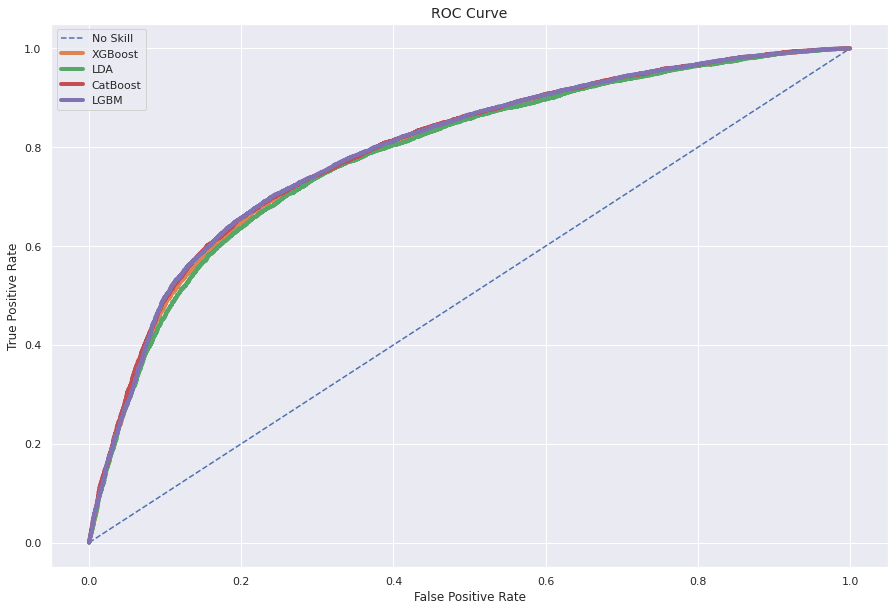

In [59]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(15, 10)

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculates the roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_pred_xgb_prob)
lda_fpr, lda_tpr, _ = roc_curve(y_test, y_pred_lda_prob)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, y_pred_lgbm_prob)
cat_fpr, cat_tpr, _ = roc_curve(y_test, y_pred_cat_prob)



# plots the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, linestyle='-', linewidth = 4 , label='XGBoost')
plt.plot(lda_fpr, lda_tpr, linestyle='-', linewidth = 4 , label='LDA')
plt.plot(cat_fpr, cat_tpr, linestyle='-', linewidth = 4 , label='CatBoost')
plt.plot(lgbm_fpr, lgbm_tpr,linestyle='-', linewidth = 4 , label='LGBM')


# sets plot features
plt.title("ROC Curve", fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# displays the legend
plt.legend()

# displays the plot
plt.show()

As observed, the ROC curve for **LGBM** presents better performance as it is farther from the No Skill line.

## 6.7 Classification report

In [60]:
 # makes the predictions
y_pred_xgb = xgb.predict(x_test)
y_pred_cat = cat.predict(x_test)
y_pred_lda = lda.predict(x_test)
y_pred_lgbm = lgbm.predict(x_test)

print('Classification Report for ' + type(xgb).__name__)
print(classification_report(y_test, y_pred_xgb))

print('\nClassification Report for ' + type(lda).__name__)
print(classification_report(y_test, y_pred_lda))

print('\nClassification Report for ' + type(lgbm).__name__)
print(classification_report(y_test, y_pred_lgbm))


print('\nClassification Report for ' + type(cat).__name__)
print(classification_report(y_test, y_pred_cat))

Classification Report for XGBClassifier
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      8729
           1       0.74      0.69      0.71      8358

    accuracy                           0.73     17087
   macro avg       0.73      0.73      0.73     17087
weighted avg       0.73      0.73      0.73     17087


Classification Report for LinearDiscriminantAnalysis
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8729
           1       0.74      0.66      0.70      8358

    accuracy                           0.72     17087
   macro avg       0.72      0.72      0.72     17087
weighted avg       0.72      0.72      0.72     17087


Classification Report for LGBMClassifier
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      8729
           1       0.74      0.69      0.72      8358

    accuracy                           0.73   

We are looking for high f1-score, CatBoost and LGBM has the same f1-score
    
- Key points **LGBM** :
    - Has less FN than LGBM
    - Has less FP than LGBM
    - Better Brier Score Loss
    - Better ROC Curve

Thus, LGBM suits best for our needs.


## 6.8 Cross Validation (LGBMClassifier)

In [61]:
# full data for cross validation
x_cv = pd.concat( [x_train, x_test ] , axis=0)
y_cv = pd.concat( [y_train, y_test ] , axis=0)

In [62]:
#kfold strategy
cv1 = StratifiedKFold( n_splits = 10)

In [63]:
#Cross Validation LGBM
print('\nCross Validation for ' + type(lgbm).__name__)

cv_scores = cross_val_score( lgbm, x_cv, np.ravel( y_cv), cv =cv1, scoring ='precision', n_jobs=-1 )
print("\n Average Precision %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lgbm, x_cv,  np.ravel (y_cv), cv =cv1, scoring ='recall', n_jobs=-1 )
print("\n Average Recall %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lgbm, x_cv, np.ravel( y_cv), cv =cv1, scoring ='f1', n_jobs=-1 )
print("\n Average F1-SCORE %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 )  )



Cross Validation for LGBMClassifier

 Average Precision 0.7490 (+/- 0.0124)

 Average Recall 0.6864 (+/- 0.0222)

 Average F1-SCORE 0.7163 (+/- 0.0154)


# 7.0 Hyperparemeter fine tuning

## 7.1 Random search


In [64]:
# classifier
lgbm_clf = LGBMClassifier(random_state=33, n_jobs=-1)

In [65]:
# dictionary with  hyperparameters
param = {'max_depth': np.arange(2, 12, 2), 
         'num_leaves': 2 ** np.arange(2, 10, 2),
         'min_data_in_leaf': np.arange(100, 1050, 50), 
         'learning_rate': np.linspace(0.001, 0.6, 15),
         'colsample_bytree': np.linspace(0.1, 1, 5),
         'subsample': np.linspace(0.25, 1, 15),
         'n_estimators': np.arange(10, 105, 15)}

In [66]:
# prepare RandomizedSearchCV 
lgbm_clf_cv = RandomizedSearchCV(estimator=lgbm_clf, param_distributions=param,
                                scoring='recall', n_iter=100, cv=10, verbose=2,
                                random_state=33, n_jobs=-1)

In [67]:
# fits 
lgbm_clf_cv.fit(x_balanced, np.ravel( y_balanced ) )

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[LightGBM] [Warning] min_data_in_leaf is set=650, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=650


RandomizedSearchCV(cv=10, estimator=LGBMClassifier(random_state=33), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'learning_rate': array([0.001     , 0.04378571, 0.08657143, 0.12935714, 0.17214286,
       0.21492857, 0.25771429, 0.3005    , 0.34328571, 0.38607143,
       0.42885714, 0.47164286, 0.51442857, 0.55721429, 0.6       ]),
                                        'max_depth': arr...
                                        'min_data_in_leaf': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000]),
                                        'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100]),
                                        'num_leaves': array([  4,  16,  64, 256]),
                                        'subsample': array([0.25      , 0.30357143, 0.357142

In [68]:
#best parameters
lgbm_clf_cv.best_estimator_


LGBMClassifier(colsample_bytree=0.775, learning_rate=0.6, max_depth=2,
               min_data_in_leaf=650, n_estimators=40, num_leaves=256,
               random_state=33, subsample=0.30357142857142855)

## 7.2 Metrics

In [69]:
#MODEL
lgbm_tuned = lgbm_clf_cv.best_estimator_

#performance
df_tuned = get_classifiers_performance(x_balanced,x_test, y_balanced, y_test, [lgbm_tuned] )
df_tuned


Training LGBMClassifier...


model  precision  recall  f1-Score  accuracy
0  LGBMClassifier    0.73352 0.70280   0.71783   0.72974

In [70]:
# Print the tuned parameters and score
print("\nTuned Parameters: {}".format(lgbm_clf_cv.best_params_)) 
print("\nBest score: {:.4f}".format(lgbm_clf_cv.best_score_))


Tuned Parameters: {'subsample': 0.30357142857142855, 'num_leaves': 256, 'n_estimators': 40, 'min_data_in_leaf': 650, 'max_depth': 2, 'learning_rate': 0.6, 'colsample_bytree': 0.775}

Best score: 0.7638


## 7.3 Cross validation

In [71]:
#Perfomance cross validation

cv_scores = cross_val_score( lgbm_tuned, x_cv, np.ravel( y_cv), cv =cv1, scoring ='precision', n_jobs=-1 )
print("Average Precision %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lgbm_tuned, x_cv,  np.ravel( y_cv ), cv =cv1, scoring ='recall', n_jobs=-1 )
print("\n Average Recall %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 ) )

cv_scores = cross_val_score( lgbm_tuned, x_cv, np.ravel( y_cv), cv =cv1, scoring ='f1', n_jobs=-1 )
print("\n Average f1-score %0.4f (+/- %0.4f)" %(cv_scores.mean(), cv_scores.std()*2 )  )

Average Precision 0.7415 (+/- 0.0090)

 Average Recall 0.7006 (+/- 0.0271)

 Average f1-score 0.7204 (+/- 0.0170)


In [72]:
#model performance business
price_per_percent = 500/5


cv_scores = cross_val_score( lgbm_tuned, x_cv, np.ravel( y_cv), cv =cv1, scoring ='precision', n_jobs=-1 )

baseline = 50
num_pacients = 70000

model_accuracy = cv_scores.mean()
deviation = cv_scores.std() * 2


accuracy_lower = (model_accuracy - deviation) * 100
accuracy_upper = (model_accuracy + deviation) * 100

percent_difference_lower = accuracy_lower - baseline
percent_difference_upper = accuracy_upper - baseline

amount_best = percent_difference_upper * price_per_percent * num_pacients
amount_worst = percent_difference_lower * price_per_percent * num_pacients

print(f'Best:  ${round(amount_best, 2):,.2f}')
print(f'Worst: ${round(amount_worst, 2):,.2f}')

Best:  $175,315,472.06
Worst: $162,776,164.32


## 7.4 Saving the tuned model 

In [73]:
#save trained model_tuned
pickle.dump( lgbm_tuned, open ( '/home/pc/Documents/PA/01/parameter/model_tuned.pkl', 'wb' ) )

#save training model not tuned
pickle.dump( lgbm, open ( '/home/pc/Documents/PA/01/parameter/model_not_tuned.pkl', 'wb' ) )

## 7.5 Cross validation summary

|     Model                                  | Avg Precision             | Avg Recall                | Avg f1\-score             
|--------------------------------------------|---------------------------|---------------------------|---------------------------
| LGBM Classifier                            | 0\.7490 \(\+/\- 0\.0124\) | 0\.6864 \(\+/\- 0\.0222\) | 0\.7163 \(\+/\- 0\.0154\) 
| LGBM Classifier \(Tuned HP\)               | 0.7415 (+/- 0\.0106\)     | 0\.7006 \(\+/\- 0\.0271\) | 0\.7204 \(\+/\- 0\.0170\) 


Although the **LGBM Classifier** has a slightly lower precision , it has a higher f1-score and recall which is fair enough for our project needs. 

# 8.0 Business performance

<font size = '4'>


The price of the diagnosis, paid by the client, varies according to the precision achieved by the team of specialists.

| Exam Accuracy | Price          | Rules                                    | Example                         |
|:--------------|:---------------|:-----------------------------------------|:--------------------------------|
| Above 50%     | min \$500\.00  | \+\$500 for each additional 5% precision | Precision = 55% \-> \$1,000\.00 |
| Up to 50%     | $0\.00         | N/A                                      | N/A                             |




<font size = 4 >

Translating my model's performance it to business numbers.

| Exam Accuracy | Best Scenario    | Worst Scenario         |
|:--------------|:-----------------|:---------------------- |
| Our Model     | \$175,315,472.06 | \$162,776,164\.32      |
| Today         | \$105,000,000.00 | \$35,000,000\.00       |  

# 9.0 Deploy model

## 9.1 Cardio Class

In [74]:
import pickle
import pandas as pd
import streamlit as st
import json



class Cardio( object ):
    
    def __init__(self):
        self.home_path = '/home/pc/Documents/PA/01'
        self.model     = pickle.load( open( self.home_path + '/parameter/model_tuned.pkl', 'rb' ) )
        
        
    def data_engineering(self , df2 ):
        #creating new features
        #blood_pressure
        df2['blood_pressure'] = df2.apply( (lambda x: 1 if (x['ap_hi'] < 120) & (x['ap_lo'] <= 80) else 2 if (120 <= x['ap_hi'] <= 129) & (x['ap_lo'] < 80) else 3 if (130 <= x['ap_hi'] < 139) or ( 80 <= x['ap_lo'] <= 89) else 4 ),axis =1 ) 

        #IMC = WEIGHT/HEIGHT^2
        df2['height2'] = df2['height']/100

        df2['bmi'] = (df2['weight']/(df2['height2']**2))

        #imc_type
        df2['bmi_type'] = df2.apply( (lambda x : 1 if x['bmi'] < 18.5 else 2 if  18.5 <= x['bmi'] < 25.0 else 3 if 25 <= x['bmi'] < 30.0 else 4 if  30.0 <= x['bmi'] < 35.0 else 5 if 35 <= x['bmi'] < 40.0 else 6) ,axis=1)

        #create columns age by year
        df2['age'] = df2['age'].apply(lambda x: x*365)
        
        #delete aux columns
        cols_drop = ['height2']
        df2 = df2.drop(cols_drop,axis=1)
        
    
        return df2
  
    def get_predict(self, model, df4 ):
        
        #features
        cols = ['age','ap_hi','bmi','weight','cholesterol','blood_pressure','ap_lo']
        df4 = df4[cols].copy()
        
        #predidction
        df4['predict'] = model.predict( df4 )
    
            
        return df4.to_json( orient='records' )
    
                


    
    


## 9.2 API Handler

## 9.3 API Tester

In [76]:
#choose one patient
df_test = df5.sample()

#filter
df_test = df_test.drop(['id','cardio'], axis=1)

#convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [77]:
#API CALL
#url = 'http://0.0.0.0:5000/cardio/predict'
url = 'https://cardio-predict.herokuapp.com/cardio/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data = data, headers=header)

print(" Status Code {}".format( r.status_code ) )

 Status Code 200


In [78]:
result = pd.DataFrame(r.json() ,columns =r.json()[0].keys() )

In [79]:
result

age  ap_hi      bmi   weight  cholesterol  blood_pressure  ap_lo  predict
0  7276640    120 22.49135 65.00000            1               3     80        1